In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload
import matplotlib.pyplot as plt

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

from tensorboardX import SummaryWriter
%load_ext line_profiler

In [13]:
device = torch.device('cuda:2')
base_model = torch.load('SavedModels/base_MNIST_lr0.001_augm_flagTrue_train_typeACET.pth')
gmm = torch.load('SavedModels/GMM/gmm_MNIST_n1000_data_used60000_augm_flagTrue_alg_scikit.pth')
model_params = params.params_dict['MNIST'](augm_flag=True, batch_size=128)

In [14]:
lam = gmm_helpers.find_lam(gmm, .5, model_params.cali_loader)
print(lam)

508.10611114501955


In [15]:
gmm.alpha = nn.Parameter(gmm.alpha)
gmm.mu.requires_grad = True
gmm.logvar.requires_grad = True
gmm.alpha.requires_grad = (False)

model = models.RobustModel(base_model, gmm, lam, dim=model_params.dim).to(device)
model.loglam.requires_grad = False

In [16]:
ran = torch.rand(50,1,28, 28).to(device)
print( base_model(ran).max(1)[0].exp() )
noise = adv.gen_adv_noise(base_model, device, ran, epsilon=.3, steps=40)
print( base_model(noise).max(1)[0].exp() )

tensor([0.1005, 0.1015, 0.1048, 0.1007, 0.1033, 0.1039, 0.1213, 0.1005, 0.1066,
        0.1035, 0.1006, 0.1008, 0.1005, 0.1066, 0.1032, 0.1152, 0.1009, 0.1006,
        0.1039, 0.1026, 0.1013, 0.1020, 0.1005, 0.1049, 0.1005, 0.1089, 0.1039,
        0.1010, 0.1008, 0.1005, 0.1106, 0.1019, 0.1018, 0.1022, 0.1491, 0.1005,
        0.1014, 0.1006, 0.1006, 0.1006, 0.1012, 0.1013, 0.1034, 0.1018, 0.1039,
        0.1023, 0.1005, 0.1027, 0.1077, 0.1007], device='cuda:2',
       grad_fn=<ExpBackward>)
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 0.9997, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9998, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9999, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000], device='cuda:2',
       grad_fn=<ExpBackward>)


In [17]:
correct, av_conf, test_loss = tt.test(model.base_model, device, model_params.test_loader)
print(correct)
print(av_conf)
print(test_loss)

correct_combined, av_conf_combined, test_loss_combined = tt.test(model, device, model_params.test_loader)
print(correct_combined)
print(av_conf_combined)
print(test_loss_combined)

0.9948
0.9928470855712891
0.01583202826976776
0.992
0.9888877990722656
0.025437997436523436


In [18]:
print( model(noise).max(1)[0].exp() )
noise = adv.gen_adv_noise(model, device, noise, epsilon=.3, steps=40)
print( model(noise).max(1)[0].exp() )

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000], device='cuda:2',
       grad_fn=<ExpBackward>)
tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000, 0.1000, 0.1000, 0.1000], device='cuda:2',
       grad_fn=<ExpBackward>)


In [19]:
model_params = params.params_dict['MNIST'](augm_flag=True)
df_base = ev.evaluate(model.base_model, device, 'MNIST', model_params.loaders)
df_combined = ev.evaluate(model, device, 'MNIST', model_params.loaders)
print(df_base)
print(df_combined)

                  MMC     AUROC  FPR@95
DataSet                                
orig         0.992847         -       -
FMNIST       0.383859  0.994957  0.0474
EMNIST       0.800431  0.913057  0.3797
GrayCIFAR10  0.101113         1       0
Noise        0.100045         1       0
                  MMC     AUROC  FPR@95
DataSet                                
orig         0.988888         -       -
FMNIST       0.234574  0.994379  0.0284
EMNIST       0.687237  0.910574  0.3278
GrayCIFAR10  0.100293  0.998113       0
Noise        0.100049  0.996631       0


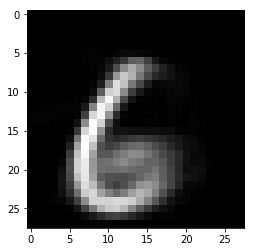

In [27]:
plt.imshow(gmm.mu[10].view(28,28).detach().cpu(), cmap='gray')

In [ ]:
torch.